In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

100%|██████████| 13.7G/13.7G [11:59<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1


In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from transformers import BertTokenizer
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from nltk.translate.bleu_score import corpus_bleu  # For evaluation

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and compute vocabulary size based on the dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)
print(f"Vocabulary Size: {vocab_size}")

# Define the COCO dataset class
class CocoDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load COCO annotations
        with open(captions_file, 'r') as f:
            data = json.load(f)

        self.image_filenames = []
        self.captions = []
        for annotation in data['annotations']:
            image_id = annotation['image_id']
            caption = annotation['caption']
            image_filename = f'COCO_train2014_{image_id:012d}.jpg'
            image_path = os.path.join(image_dir, image_filename)
            if os.path.exists(image_path):  # Ensure file exists
                self.image_filenames.append(image_path)
                self.captions.append(caption)

        # Limit to max_samples if provided
        if max_samples:
            self.image_filenames = self.image_filenames[:max_samples]
            self.captions = self.captions[:max_samples]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_filenames[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption = self.captions[idx]
        tokenized_caption = tokenizer(caption, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
        input_ids = tokenized_caption["input_ids"].squeeze(0)
        attention_mask = tokenized_caption["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask

# Define the captioning model
class CaptioningModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CaptioningModel, self).__init__()
        # Load ResNet and remove the last fully connected layer
        self.resnet = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-2])  # Remove FC and pooling layers
        self.resnet_fc = torch.nn.Linear(2048, embed_size)

        # Embedding and LSTM layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, images, captions):
        # Extract features from images
        features = self.resnet(images)
        features = features.mean([2, 3])  # Global Average Pooling
        features = self.resnet_fc(features)

        # Embed captions
        embedded = self.embedding(captions)
        features = features.unsqueeze(1)  # Add sequence dimension
        inputs = torch.cat((features, embedded), dim=1)

        # LSTM outputs
        outputs, _ = self.lstm(inputs)
        outputs = self.fc_out(outputs)
        return outputs

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset paths
image_dir = "/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014"
captions_file = "/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json"

# Load the first 10000 samples
max_samples = 100000
dataset = CocoDataset(image_dir, captions_file, transform=transform, max_samples=max_samples)

# Split the dataset into train, val, and test (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Ensure reproducibility
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, optimizer, and scheduler
model = CaptioningModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as batch_bar:
        for images, input_ids, attention_mask in batch_bar:
            # Move images and input_ids to the correct device
            images, input_ids = images.to(device), input_ids.to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            outputs_trimmed = outputs[:, :seq_len, :]
            target_ids = input_ids[:, 1:seq_len + 1]

            outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
            target_flat = target_ids.reshape(-1)

            loss = criterion(outputs_flat, target_flat)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            batch_bar.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, input_ids, _ in val_loader:
            # Move images and input_ids to the correct device
            images, input_ids = images.to(device), input_ids.to(device)
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            outputs_trimmed = outputs[:, :seq_len, :]
            target_ids = input_ids[:, 1:seq_len + 1]

            outputs_flat = outputs_trimmed.reshape(-1, vocab_size)
            target_flat = target_ids.reshape(-1)

            loss = criterion(outputs_flat, target_flat)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}")

# Save the best model based on validation loss
torch.save(model.state_dict(), "best_captioning_model.pth")

# BLEU Score Evaluation
def evaluate_bleu_score(model, data_loader, tokenizer, max_length=50):
    references = []
    predictions = []

    model.eval()
    with torch.no_grad():
        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            outputs = model(images, input_ids)

            seq_len = min(outputs.size(1), input_ids.size(1) - 1)
            predicted_ids = outputs.argmax(dim=-1)

            for i in range(len(input_ids)):
                # Get ground truth
                ref_caption = tokenizer.decode(input_ids[i], skip_special_tokens=True).split()
                references.append([ref_caption])

                # Get predicted caption
                pred_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True).split()
                predictions.append(pred_caption)

    return corpus_bleu(references, predictions)

# Evaluate BLEU score on the validation set
bleu_score = evaluate_bleu_score(model, val_loader, tokenizer)
print(f"BLEU score on the validation set: {bleu_score}")


Using device: cuda
Vocabulary Size: 30522


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Epoch 1/3: 100%|██████████| 2188/2188 [26:07<00:00,  1.40batch/s, loss=3.74]


Epoch 1/3, Training Loss: 4.138858615589316, Validation Loss: 3.8143587234432


Epoch 2/3: 100%|██████████| 2188/2188 [25:28<00:00,  1.43batch/s, loss=3.48]


Epoch 2/3, Training Loss: 3.5972762828117313, Validation Loss: 3.6764737334586917


Epoch 3/3: 100%|██████████| 2188/2188 [25:23<00:00,  1.44batch/s, loss=3.54]


Epoch 3/3, Training Loss: 3.339529395212421, Validation Loss: 3.6315926854798533
BLEU score on the validation set: 0.04438005294983559


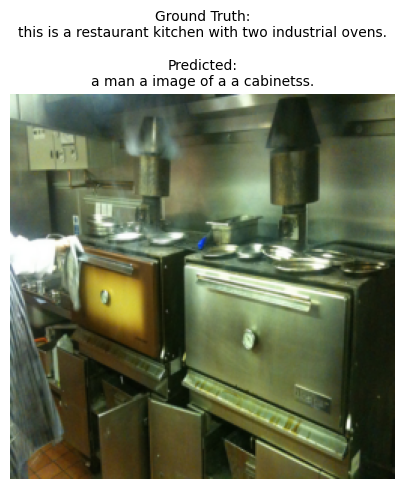

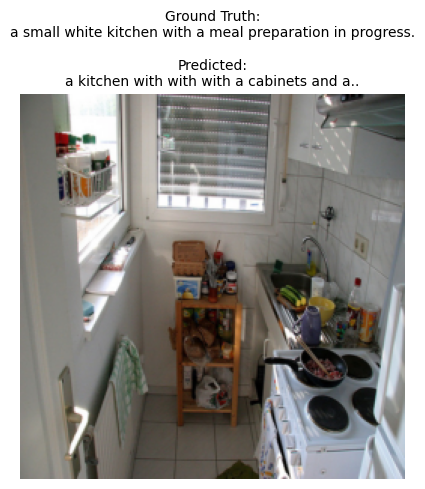

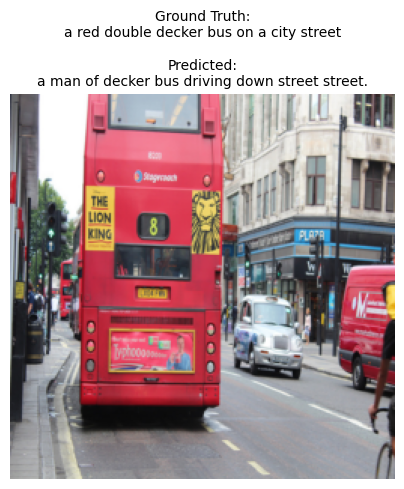

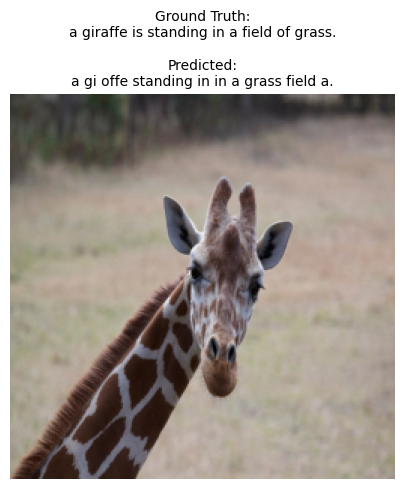

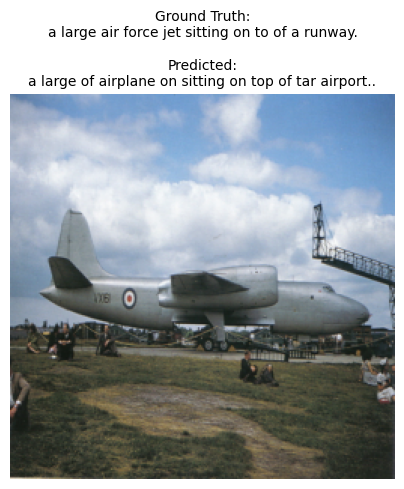

In [ ]:
import matplotlib.pyplot as plt

def display_examples(data_loader, model, tokenizer, num_examples=5):
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)

            # Get predictions
            outputs = model(images, input_ids)
            predicted_ids = outputs.argmax(dim=-1)

            for i in range(len(images)):
                if examples_shown >= num_examples:
                    return

                # Decode ground truth caption
                ground_truth = tokenizer.decode(input_ids[i], skip_special_tokens=True)

                # Decode predicted caption
                predicted_caption = tokenizer.decode(predicted_ids[i], skip_special_tokens=True)

                # Display image and captions
                image = images[i].cpu().permute(1, 2, 0)  # Convert to HWC format
                image = (image * torch.tensor([0.229, 0.224, 0.225]) +
                         torch.tensor([0.485, 0.456, 0.406])).clip(0, 1)  # De-normalize

                plt.figure(figsize=(5, 5))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Ground Truth:\n{ground_truth}\n\nPredicted:\n{predicted_caption}", fontsize=10)
                plt.show()

                examples_shown += 1

# Call the function to display examples from the validation set
display_examples(val_loader, model, tokenizer, num_examples=5)


In [4]:
from google.colab import files

# Specify the file to download
file_path = "/content/best_captioning_model.pth"

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>